# Load libraries and Network results

In [151]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Sep 25 10:40:42 2020

@author: sturkars
"""
import os
import sys
import glob
import numpy as np
import pandas as pd
#import miner as miner
from scipy.stats import zscore
import miner_py3_kk as miner
from tqdm.notebook import tqdm, trange
import time

# change the working directory
#os.chdir('/Users/serdarturkaslan/Documents/GitHub/GbmMINER/data/MINER_MicroLowessRNATMM.08.24.2020/')
# output directory
output_dir = "/Volumes/omics4tb2/SYGNAL/XCures"

# Path to the miner directory
input_path = "/Volumes/omics4tb2/SYGNAL/GBM-Serdar/MINER_MicroLowessRNATMM.08.24.2020"
print("Libraries loaded!")

Libraries loaded!


# Function to load regulons

In [152]:
def loadRegulons(disease_relevant=True,disease_relevant_regulons_file="regulonDfGbmMicroRNASigCoxAndStatSig.csv"):
    
    # Load regulon Modules
    regulonModules = miner.read_json(os.path.join(input_path,"regulons.json"))
    print("Total number of regulons: " + str(len(regulonModules)))

    # load regulon data frame
    # All Regulons
    regulonDf = pd.read_csv(os.path.join(input_path, "regulonDf.csv"), header = 0)
    regulonDf = list(regulonDf['Regulon_ID'].drop_duplicates())
    regulonDf = [str(i) for i in regulonDf]

    # Disease relevant regulons
    regulonDfMicroGbmLatest = pd.read_csv(os.path.join(input_path,disease_relevant_regulons_file), header = 0)
    regulonDfMicroGbmLatest = list(regulonDfMicroGbmLatest['Regulon_ID'].drop_duplicates())
    regulonDfMicroGbmLatest = [str(i) for i in regulonDfMicroGbmLatest]
    regulonModulesFiltered = dict((k, regulonModules[k]) for k in regulonDfMicroGbmLatest if k in regulonModules)
    print("Filtered number of regulons: " + str(len(regulonModulesFiltered)))
    
    if disease_relevant == True:
        #regulonModules = dict((k, regulonModules[k]) for k in regulonDfMicroGbmLatest if k in regulonModules)
        regulonModules = regulonModulesFiltered 
        print("Returned %s filtered regulons" %(str(len(regulonModules))))
        return(regulonModules)
    
    else:
        regulonModules = dict((k, regulonModules[k]) for k in regulonDf if k in regulonModules)
        print("Returned %s Total regulons" %(str(len(regulonModules))))
        return(regulonModules)

# Function to load Programs 

In [153]:
def loadPrograms(disease_relevant=True,disease_relevant_programs_file="transcriptional_programsmiRNAAndSig.json"):
    
    # Load transcriptional programs
    # All Programs
    transcriptional_programs = miner.read_json(os.path.join(input_path,'transcriptional_programs.json'))
    print("Total # of programs: ", str(len(transcriptional_programs)))
    
    transcriptional_programs_filtered = miner.read_json(os.path.join(input_path,disease_relevant_programs_file))
    print("Filtered # of programs: ", str(len(transcriptional_programs_filtered)))
    
    if disease_relevant == True:
            transcriptional_programs = transcriptional_programs_filtered
            print("Returned %s filtered Programs" %(str(len(transcriptional_programs_filtered))))
    else:
        transcriptional_programs = transcriptional_programs
        print("Returned %s Total Programs" %(str(len(transcriptional_programs))))

    program_list = [transcriptional_programs[str(key)] for key in range(len(transcriptional_programs.keys()))]
    
    return(program_list)

# Function to create dictionary of program genes

In [154]:
# Create dictionary of program genes
# make dictionary of program keys with gene lists as elements
def createPrGenesDictionary(program_list, regulons):
    pr_genes_expanded = {}
    for i in range(len(program_list)):
        rgns = program_list[i]
        genes = []
        for r in rgns:
            if r in regulons:
                genes.append(regulons[r])
        if len(genes) != 0:
            genes = list(set(np.hstack(genes)))
            pr_genes_expanded[i] = genes

    unique_genes = set(x for y in pr_genes_expanded.values() for x in y)
        
    print("Total number of genes: " + str(len(unique_genes)))
    return(pr_genes_expanded)


# Function to calculate Program activity

In [155]:
def calculateProgramActivity(program_list,regulons,expressionData,referenceDictionary,outputFile):
    
    # create a background matrix used for statistical hypothesis testing
    bkgd = miner.backgroundDf(expressionData)

    # for each cluster, give samples that show high coherent cluster activity
    overExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.05)

    # for each clus|ter, give samples that show low coherent cluster activity
    underExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.05)

    # convert overExpressedMembers dictionary to binary matrix
    overExpressedProgramsMatrix = miner.membershipToIncidence(overExpressedMembers,expressionData)

    # convert underExpressedMembers dictionary to binary matrix
    underExpressedProgramsMatrix = miner.membershipToIncidence(underExpressedMembers,expressionData)

    # Create program matrix with values of {-1,0,1}
    dfr_programs = overExpressedProgramsMatrix-underExpressedProgramsMatrix
    
    # Write program activity into a outFile
    dfr_programs.to_csv(outputFile)
    
    return(dfr_programs)

# Load Regulons

In [156]:
# load disease relevant regulons
regulonModulesDisease = loadRegulons(disease_relevant=True)

#load all regulons
regulonModulesAll = loadRegulons(disease_relevant=False)

Total number of regulons: 3764
Filtered number of regulons: 505
Returned 505 filtered regulons
Total number of regulons: 3764
Filtered number of regulons: 505
Returned 3764 Total regulons


# Load ribosomal gene list

In [157]:
# Load list of ribosomal proteisn to filter the expression data
ribosomal = pd.read_csv("../data/ribosomal_proteins.txt", header=0,index_col=0,sep="\t")
ribosomal = list(ribosomal["Ensembl gene ID"])

# Load background genes

In [158]:
# We either use the MINER input expressioin genes as background or all propgram genes
def loadBackgroundGenes(backgd_type = "input"):
    if backgd_type == "input":
        # Use model input genes as background
        # Filter gene expression data only for genes that were in the model building data
        model_input_data = pd.read_csv(os.path.join(input_path,'GbmMicroRNAMergedWithIDsZScored.csv'),header=0,index_col=None,sep=",")
        model_input_genes = list(model_input_data['Unnamed: 0'])
        bkgd_genes = [item for sublist in model_input_genes for item in sublist]
        
        bkgd_genes = set(model_input_genes)
        print("background Genes:" + str(len(bkgd_genes)))
        bkgd_genes = [x for x in bkgd_genes if x not in ribosomal]
        print("background Genes after ribosomal remove:" + str(len(bkgd_genes)))
        return(bkgd_genes)
        
       
    if backgd_type == "program":
        # Use program genes as background
        # Filter gene expression data only for program genes across all programs
        program_list = loadPrograms(disease_relevant=False)
        referenceDictionary = createPrGenesDictionary(program_list, regulonModulesAll)
        my_genes =list(referenceDictionary.values())
        bkgd_genes = [item for sublist in my_genes for item in sublist]
        bkgd_genes = set(bkgd_genes)
        print("background Genes:" + str(len(bkgd_genes)))
        bkgd_genes = [x for x in bkgd_genes if x not in ribosomal]
        print("background Genes after ribosomal remove:" + str(len(bkgd_genes)))
        return(bkgd_genes)

# Load Programs

In [159]:
# load disease relevant programs
program_list_disease = loadPrograms(disease_relevant=True)

# load all programs
program_list_all = loadPrograms(disease_relevant=False)

Total # of programs:  178
Filtered # of programs:  33
Returned 33 filtered Programs
Total # of programs:  178
Filtered # of programs:  33
Returned 178 Total Programs


# Load data folders

In [160]:
# Folders for patient data
patientDataFolders = glob.glob('/Volumes/omics4tb2/SYGNAL/XCures/patients_processed_data/*')
patientDataFolders = list(filter(lambda x:('TL-' in x or 'P76156' in x) , patientDataFolders))
patientDataFolders = list(filter(lambda x:('TL-20-F66315' not in x) , patientDataFolders))

print('Total Patients to process: %s' %(len(patientDataFolders)))

Total Patients to process: 13


# Function to calculate activity stats

In [161]:
def activityStats(inputDf,label,patientID):
    
# calculate regulon or program activity stats
    overActiveCount = len(inputDf[inputDf[patientID] == 1])
    underActiveCount = len(inputDf[inputDf[patientID] == -1])
    neutralCount = len(inputDf[inputDf[patientID] == 0])

    resSummary = {"Over" : [overActiveCount],
                          "Under" : [underActiveCount],
                          "Neutral" : [neutralCount],
                  "Type" : label
                 }
    resSummary = pd.DataFrame(resSummary)
    resSummary = resSummary.rename(index={0: patientID})
    return(resSummary)

# Function to plot processed & Raw data

In [162]:
import matplotlib.pyplot as plt

def processingPlots(gene, patient, expressionData):
    # gene to plot
    if gene is None:
        gene_data = expressionData.iloc[0,:]
    else:
        gene_data = expressionData.loc[gene,:]
              
    # patient to plot
    if patient is None:
        patient_data = expressionData.iloc[:,0]
    else:
        patient_data = expressionData.loc[:,patient] 
    
    # get first 100 patient to plot
    individual_expression_data = [expressionData.iloc[:,i] for i in range(100)]
    
    _ = plt.boxplot(individual_expression_data)
    plt.title("Patient expression profiles",fontsize=14)
    plt.ylabel("Relative expression",fontsize=14)
    plt.xlabel("Sample ID",fontsize=14)
    plt.figure()

    _ = plt.hist(gene_data,bins=100,alpha=0.75)
    plt.title("Expression of %s" %(gene),fontsize=14)
    plt.ylabel("Frequency",fontsize=14)
    plt.xlabel("Relative expression",fontsize=14)
    plt.figure()
    
    _ = plt.hist(patient_data,bins=200,color=[0,0.4,0.8],alpha=0.75)
    plt.ylim(0,200)
    plt.title("Expression of patient: %s" %(patient),fontsize=14)
    plt.ylabel("Frequency",fontsize=14)
    plt.xlabel("Relative expression",fontsize=14)

# Preprocess patient + cohort data

In [163]:
#output_dir = "/Volumes/omics4tb2/SYGNAL/XCures"

# Load patients data combined with cohort rnaseq tpms
combined_patient_cohort_filename = os.path.join("/Volumes/omics4tb2/SYGNAL/XCures/patients_processed_data/allpatients_withcohort_tpm.csv")
# read cohort + patient data
rawExpression = miner.readFileToDf(combined_patient_cohort_filename)

# remove Null rows
rawExpressionZeroFiltered = miner.removeNullRows(rawExpression)

# correct batch effects
zscoredExpression = miner.correctBatchEffects(rawExpressionZeroFiltered)

completed z-transformation.


In [164]:
zscoredExpression.to_csv(os.path.join("/Volumes/omics4tb2/SYGNAL/XCures/patients_processed_data/allpatients_withcohort_zscores.csv"))

# Raw data inspection

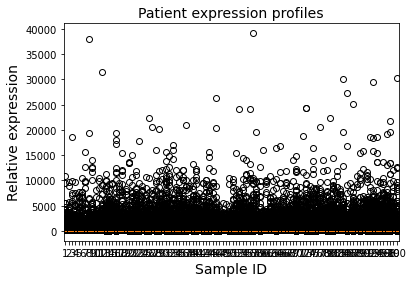

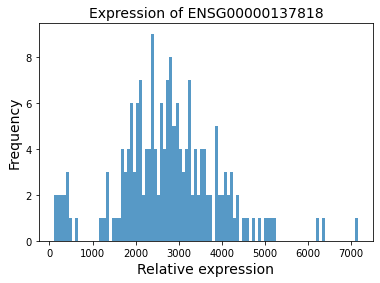

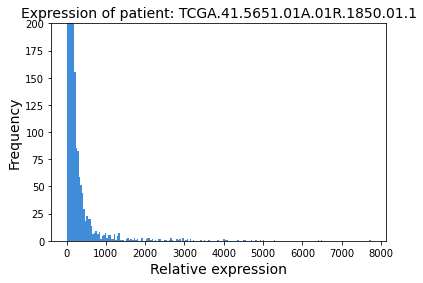

In [165]:
processingPlots("ENSG00000137818","TCGA.41.5651.01A.01R.1850.01.1",rawExpression )

# Processed data inspection

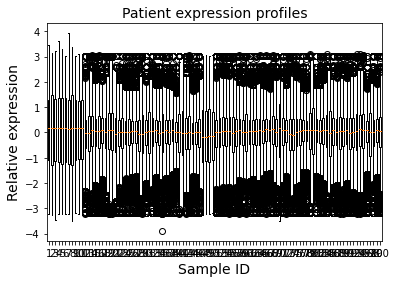

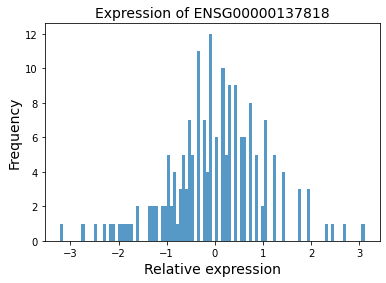

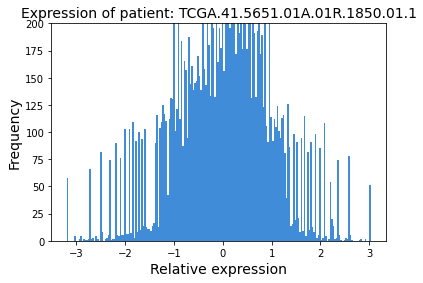

In [166]:
processingPlots("ENSG00000137818","TCGA.41.5651.01A.01R.1850.01.1",zscoredExpression )

# Analyze patient data

In [167]:
# laod Background genes
bkgd_genes = loadBackgroundGenes(backgd_type="input")

# For all programs, select reference dictionary for downstream analysis (pr_genes, revisedClusters, coexpressionModules, or regulonModules)
referenceDictionaryAll = createPrGenesDictionary(program_list_all,regulonModulesAll)

# For disease relevant programs, select reference dictionary for downstream analysis (pr_genes, revisedClusters, coexpressionModules, or regulonModules)
referenceDictionaryDisease = createPrGenesDictionary(program_list_disease,regulonModulesDisease)


# Patient analysis loop
allSummary = pd.DataFrame()
for folder in tqdm(patientDataFolders):
    time.sleep(0.01)
    patientID = folder.split('/')[-1] #get patientID
    print(patientID)
    patientDataFile = pd.DataFrame(zscoredExpression[patientID]) # get RNASeq results
    
    expressionData = patientDataFile
    # create patent activity output folder if it doesnt exist already
    activity_output_dir = os.path.join(output_dir,"patients_network_activities",patientID)
    
    if not os.path.exists('%s' %(activity_output_dir)):
        os.makedirs(activity_output_dir)
   
    ############### Regulon Activity ###############
    # calculate disease relevant regulon activity 
    rr = miner.generateRegulonActivity(regulonModulesDisease,expressionData, p=0.05)
    
    # calculate all regulon activity 
    aa = miner.generateRegulonActivity(regulonModulesAll,expressionData, p=0.05)

    ############### Program Activity ###############
    # calculate disease relevant program activity
    program_activity_disease = calculateProgramActivity(program_list_disease,regulonModulesDisease,expressionData,referenceDictionaryDisease,outputFile= os.path.join(activity_output_dir,patientID) + "_disease_rel_program_activity.csv")

    # calculate all program activity
    program_activity_all = calculateProgramActivity(program_list_all,regulonModulesAll,expressionData,referenceDictionaryAll,outputFile= os.path.join(activity_output_dir,patientID) + "_all_program_activity.csv")

    # write disease relevant regulon activity results to filr
    rr.to_csv(os.path.join(activity_output_dir,patientID) + "_disease_rel_regulon_activity.csv")

    # write all regulon activity results to file
    aa.to_csv(os.path.join(activity_output_dir,patientID) + "_all_regulon_activity.csv")

    # calculate regulon activity stats for disease relevant regulons

    sum1 = activityStats(rr,"Disease Relevant Regulons",patientID)
    sum2 = activityStats(aa,"All Regulons",patientID)
    sum3 = activityStats(program_activity_disease,"Disease Relevant Programs",patientID)
    sum4 = activityStats(program_activity_all,"All Programs",patientID)

    allSummary = pd.concat([allSummary,sum1,sum2,sum3,sum4])

print(allSummary)


background Genes:9728
background Genes after ribosomal remove:9614
Total number of genes: 6781
Total number of genes: 1862


  0%|          | 0/13 [00:00<?, ?it/s]

TL-19-61DB85
biclusterMembershipDictionary is done!
biclusterMembershipDictionary is done!
biclusterMembershipDictionary is done!
biclusterMembershipDictionary is done!
biclusterMembershipDictionary is done!
biclusterMembershipDictionary is done!
biclusterMembershipDictionary is done!
biclusterMembershipDictionary is done!
TL-19-87E3E1
biclusterMembershipDictionary is done!
biclusterMembershipDictionary is done!
biclusterMembershipDictionary is done!
biclusterMembershipDictionary is done!
biclusterMembershipDictionary is done!
biclusterMembershipDictionary is done!
biclusterMembershipDictionary is done!
biclusterMembershipDictionary is done!
TL-20-0B6792
biclusterMembershipDictionary is done!
biclusterMembershipDictionary is done!
biclusterMembershipDictionary is done!
biclusterMembershipDictionary is done!
biclusterMembershipDictionary is done!
biclusterMembershipDictionary is done!
biclusterMembershipDictionary is done!
biclusterMembershipDictionary is done!
TL-20-24CC77
biclusterMem

In [ ]:
             Over  Under  Neutral                       Type
TL-19-61DB85    64     41      400  Disease Relevant Regulons
TL-19-61DB85   580    360     2824               All Regulons
TL-19-61DB85     5      4       24  Disease Relevant Programs
TL-19-61DB85    39     19      120               All Programs
TL-19-87E3E1    73     35      397  Disease Relevant Regulons
TL-19-87E3E1   612    319     2833               All Regulons
TL-19-87E3E1     5      4       24  Disease Relevant Programs
TL-19-87E3E1    42     22      114               All Programs
TL-20-0B6792    90     35      380  Disease Relevant Regulons
TL-20-0B6792   767    347     2650               All Regulons
TL-20-0B6792     8      5       20  Disease Relevant Programs
TL-20-0B6792    49     22      107               All Programs
TL-20-24CC77    41     83      381  Disease Relevant Regulons
TL-20-24CC77   498    400     2866               All Regulons
TL-20-24CC77     4      6       23  Disease Relevant Programs
TL-20-24CC77    35     23      120               All Programs
TL-20-495B84    36     43      426  Disease Relevant Regulons
TL-20-495B84   496    326     2942               All Regulons
TL-20-495B84     2      3       28  Disease Relevant Programs
TL-20-495B84    38     20      120               All Programs
TL-20-920D6D    30    121      354  Disease Relevant Regulons
TL-20-920D6D   496    522     2746               All Regulons
TL-20-920D6D     1     11       21  Disease Relevant Programs
TL-20-920D6D    36     37      105               All Programs
TL-20-C7EDD0    75     18      412  Disease Relevant Regulons
TL-20-C7EDD0   655    271     2838               All Regulons
TL-20-C7EDD0     8      2       23  Disease Relevant Programs
TL-20-C7EDD0    45     18      115               All Programs
TL-20-E2D448    56     98      351  Disease Relevant Regulons
TL-20-E2D448   554    489     2721               All Regulons
TL-20-E2D448     4      8       21  Disease Relevant Programs
TL-20-E2D448    38     37      103               All Programs
TL-21-3FD45C    46     52      407  Disease Relevant Regulons
TL-21-3FD45C   561    365     2838               All Regulons
TL-21-3FD45C     3      4       26  Disease Relevant Programs
TL-21-3FD45C    36     21      121               All Programs
TL-19-0B9A1B    64     48      393  Disease Relevant Regulons
TL-19-0B9A1B   647    382     2735               All Regulons
TL-19-0B9A1B     5      6       22  Disease Relevant Programs
TL-19-0B9A1B    44     25      109               All Programs
TL-18-31DCF0    62     23      420  Disease Relevant Regulons
TL-18-31DCF0   515    311     2938               All Regulons
TL-18-31DCF0     7      4       22  Disease Relevant Programs
TL-18-31DCF0    40     22      116               All Programs
P76156_3        65     25      415  Disease Relevant Regulons
P76156_3       704    251     2809               All Regulons
P76156_3         6      3       24  Disease Relevant Programs
P76156_3        45     15      118               All Programs
P76156_6        38     64      403  Disease Relevant Regulons
P76156_6       508    344     2912               All Regulons
P76156_6         3      8       22  Disease Relevant Programs
P76156_6        39     32      107               All Programs

# Previous versions

# Loop through each patient to calculate Regulon & Program activity

In [56]:
# laod Background genes
bkgd_genes = loadBackgroundGenes(backgd_type="input")

# Patient analysis loop
allSummary = pd.DataFrame()
for folder in tqdm(patientDataFolders[1:2]):
    time.sleep(0.01)
    patientID = folder.split('/')[-1] #get patientID
    print(patientID)
    patientDataFile = os.path.join(folder,"RNA",patientID + ".genes.results") # get RNASeq results
    
    # create patent activity output folder if it doesnt exist already
    activity_output_dir = os.path.join(output_dir,"patients_network_activities",patientID)
    
    # Check if patient data file exists
    if os.path.exists('%s' %(patientDataFile)):
        # create a new column with patient name
        newColName = patientID + "_zscore"
        
        # Read expression data
        rawExpressionData = pd.read_csv(patientDataFile, sep="\t", index_col=None, header = 0)
        #print(rawExpressionData.head)
        
        # seperate ensembl gene ids and symbols
        rawExpressionData[['GeneID','gene_symbol']] = pd.DataFrame(rawExpressionData).gene_id.str.split("_",expand=True)
        #print(rawExpressionData)
        
        # Filter ncRNAs or ribosomal RNAs
        rawExpressionData = rawExpressionData[-rawExpressionData.GeneID.isin(ribosomal)].copy()
        #print(rawExpressionData)
        
        # filter for genes in all programs
        #rawExpressionDataFilt = rawExpressionData[rawExpressionData.GeneID.isin(uniqueProteins)].copy()
        rawExpressionDataFilt = rawExpressionData[rawExpressionData.GeneID.isin(bkgd_genes)].copy()
        #rawExpressionDataFilt = rawExpressionData.loc[rawExpressionData.GeneID in my_genes]
        #rawExpressionDataFilt = rawExpressionData
        #rawExpressionDataFilt.head()
        #print("Filtered raw expression")
        #print(rawExpressionDataFilt)
        
        # zscore patients expression data (if not z-scored)
        #rawExpressionDataFilt[[newColName]] = rawExpressionDataFilt[['TPM']].apply(zscore)
        #rawExpressionDataFilt
        #expressionData = pd.read_csv("abundanceXCuresRNATPMTL1961DB85ZScoredLatest.csv", sep=",", index_col=0, header = 0)
        #expressionData = rawExpressionDataFilt[[patientID + "_zscore"]]
        #expressionData.index = rawExpressionDataFilt['GeneID']
        #print(expressionData)
        
        
         # seperate ensembl gene ids and symbols
        rawExpressionDataFilt[['GeneID','gene_symbol']] = pd.DataFrame(rawExpressionDataFilt).gene_id.str.split("_",expand=True)
        #print(rawExpressionData)
        rawExpressionData = rawExpressionDataFilt[['GeneID','TPM']]
        
        rawExpressionData.to_csv(os.path.join(folder,"RNA",str(patientID) + "_tpm.csv"), index=False)
        #sys.exit
        print(rawExpressionData.head())
        expressionData, conversionTable = miner.preprocess(os.path.join(folder,"RNA",patientID + "_tpm.csv"))
        expressionData.to_csv(os.path.join(folder,"RNA",patientID + "_tpm_exp.csv"), index=False)

        print(expressionData.head())
        print("Processed: " + patientDataFile)
        #referenceDictionary = regulonModulesDisease
        # create a background matrix used for statistical hypothesis testing
        #bkgd = miner.backgroundDf(expressionData)
        
        # for each cluster, give samples that show high coherent cluster activity
        #overExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.05)
        
        # for each clus|ter, give samples that show low coherent cluster activity
        #underExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.05)
        
        # convert overExpressedMembers dictionary to binary matrix
        #overExpressedMembersMatrix = miner.membershipToIncidence(overExpressedMembers,expressionData)
        #overExpressedMembersMatrix.index = np.array(overExpressedMembersMatrix.index).astype(str)
        
        # convert underExpressedMembers dictionary to binary matrix
        #underExpressedMembersMatrix = miner.membershipToIncidence(underExpressedMembers,expressionData)
        #underExpressedMembersMatrix.index = np.array(underExpressedMembersMatrix.index).astype(str)

        # Create program matrix with values of {-1,0,1}
        #rr = overExpressedMembersMatrix-underExpressedMembersMatrix
        #rr = miner.generateRegulonActivity(regulonModulesDisease,expressionData, p=0.05)
        #print(dfr_regulons)
        # 
        ############### Regulon Activity ###############
        # calculate disease relevant regulon activity 
        rr = miner.generateRegulonActivity(regulonModulesDisease,expressionData, p=0.05)
        #print(rr)
        
        # calculate all regulon activity 
        aa = miner.generateRegulonActivity(regulonModulesAll,expressionData, p=0.05)
        #print(rr)
        
        ############### Program Activity ###############
        # calculate disease relevant program activity
        program_activity_disease = calculateProgramActivity(program_list_disease,regulonModulesDisease,expressionData,outputFile= os.path.join(activity_output_dir,patientID) + "_disease_rel_program_activity.csv")
        #program_activity_disease = miner.generateProgramActivity(program_list_disease, regulonModulesDisease, expressionData, p=0.05, returnBkgd="no")
        
        # calculate all program activity
        program_activity_all = calculateProgramActivity(program_list_all,regulonModulesAll,expressionData,outputFile= os.path.join(activity_output_dir,patientID) + "_all_program_activity.csv")
    
        # write disease relevant regulon activity results to filr
        rr.to_csv(os.path.join(activity_output_dir,patientID) + "_disease_rel_regulon_activity.csv")
        print(rr.head)
        
        # write all regulon activity results to file
        aa.to_csv(os.path.join(activity_output_dir,patientID) + "_all_regulon_activity.csv")
        
        # calculate regulon activity stats for disease relevant regulons
        
        sum1 = activityStats(rr,"Disease Relevant Regulons")
        sum2 = activityStats(aa,"All Regulons")
        sum3 = activityStats(program_activity_disease,"Disease Relevant Programs")
        sum4 = activityStats(program_activity_all,"All Programs")
        
        allSummary = pd.concat([allSummary,sum1,sum2,sum3,sum4])
        
    else:
        print("Data file doesnt exist: " + patientDataFile) 
print(allSummary)
        

background Genes:9728
background Genes after ribosomal remove:9614


  0%|          | 0/1 [00:00<?, ?it/s]

TL-19-87E3E1
            GeneID    TPM
0  ENSG00000000003  21.84
1  ENSG00000000005   0.20
2  ENSG00000000419  46.71
3  ENSG00000000457   8.98
4  ENSG00000000460  21.94
completed z-transformation.
completed identifier conversion.
9148 genes were converted.
                 TPM
ENSG00000138696  NaN
ENSG00000104332  NaN
ENSG00000153002  NaN
ENSG00000003989  NaN
ENSG00000169442  NaN
Processed: /Volumes/omics4tb2/SYGNAL/XCures/patients_processed_data/TL-19-87E3E1/RNA/TL-19-87E3E1.genes.results
biclusterMembershipDictionary is done!
biclusterMembershipDictionary is done!
biclusterMembershipDictionary is done!
biclusterMembershipDictionary is done!
Total number of genes: 1862
biclusterMembershipDictionary is done!
biclusterMembershipDictionary is done!
Total number of genes: 6781
biclusterMembershipDictionary is done!
biclusterMembershipDictionary is done!
<bound method NDFrame.head of       TPM
0     0.0
4     0.0
6     0.0
14    0.0
23    0.0
...   ...
3675  0.0
3703  0.0
3707  0.0
3727  0

In [12]:
            Neutral  Over                       Type  Under
TL-19-61DB85      365   108  Disease Relevant Regulons     32
TL-19-61DB85     2651   787               All Regulons    326
TL-19-61DB85       22     9  Disease Relevant Programs      2
TL-19-61DB85      108    48               All Programs     22
TL-19-87E3E1      349   118  Disease Relevant Regulons     38
TL-19-87E3E1     2597   845               All Regulons    322
TL-19-87E3E1       19     9  Disease Relevant Programs      5
TL-19-87E3E1      106    49               All Programs     23
TL-20-0B6792      338   149  Disease Relevant Regulons     18
TL-20-0B6792     2649   865               All Regulons    250
TL-20-0B6792       20    11  Disease Relevant Programs      2
TL-20-0B6792      111    47               All Programs     20
TL-20-24CC77      359    96  Disease Relevant Regulons     50
TL-20-24CC77     2683   720               All Regulons    361
TL-20-24CC77       19     9  Disease Relevant Programs      5
TL-20-24CC77      105    48               All Programs     25
TL-20-495B84      406    76  Disease Relevant Regulons     23
TL-20-495B84     2814   675               All Regulons    275
TL-20-495B84       23     8  Disease Relevant Programs      2
TL-20-495B84      115    42               All Programs     21
TL-20-920D6D      377    58  Disease Relevant Regulons     70
TL-20-920D6D     2682   670               All Regulons    412
TL-20-920D6D       21     6  Disease Relevant Programs      6
TL-20-920D6D      110    45               All Programs     23
TL-20-C7EDD0      363   120  Disease Relevant Regulons     22
TL-20-C7EDD0     2680   786               All Regulons    298
TL-20-C7EDD0       20    10  Disease Relevant Programs      3
TL-20-C7EDD0      108    47               All Programs     23
TL-20-E2D448      364    86  Disease Relevant Regulons     55
TL-20-E2D448     2610   742               All Regulons    412
TL-20-E2D448       20     8  Disease Relevant Programs      5
TL-20-E2D448      103    48               All Programs     27
TL-21-3FD45C      391    80  Disease Relevant Regulons     34
TL-21-3FD45C     2701   719               All Regulons    344
TL-21-3FD45C       23     7  Disease Relevant Programs      3
TL-21-3FD45C      104    50               All Programs     24
TL-19-0B9A1B      363   114  Disease Relevant Regulons     28
TL-19-0B9A1B     2648   827               All Regulons    289
TL-19-0B9A1B       18     9  Disease Relevant Programs      6
TL-19-0B9A1B      111    44               All Programs     23
TL-18-31DCF0      364   124  Disease Relevant Regulons     17
TL-18-31DCF0     2750   742               All Regulons    272
TL-18-31DCF0       19    11  Disease Relevant Programs      3
TL-18-31DCF0      113    43               All Programs     22

SyntaxError: invalid syntax (<ipython-input-12-c2822a3c538f>, line 1)

In [ ]:
              Over  Under  Neutral                      Type
TL-19-61DB85    48     22      108  Disease Relevant Regulon
TL-19-61DB85   787    326     2651               All Regulon
TL-19-87E3E1    49     23      106  Disease Relevant Regulon
TL-19-87E3E1   845    322     2597               All Regulon
TL-20-0B6792    47     20      111  Disease Relevant Regulon
TL-20-0B6792   865    250     2649               All Regulon
TL-20-24CC77    48     25      105  Disease Relevant Regulon
TL-20-24CC77   720    361     2683               All Regulon
TL-20-495B84    42     21      115  Disease Relevant Regulon
TL-20-495B84   675    275     2814               All Regulon
TL-20-920D6D    45     23      110  Disease Relevant Regulon
TL-20-920D6D   670    412     2682               All Regulon
TL-20-C7EDD0    47     23      108  Disease Relevant Regulon
TL-20-C7EDD0   786    298     2680               All Regulon
TL-20-E2D448    48     27      103  Disease Relevant Regulon
TL-20-E2D448   742    412     2610               All Regulon
TL-21-3FD45C    50     24      104  Disease Relevant Regulon
TL-21-3FD45C   719    344     2701               All Regulon
TL-19-0B9A1B    44     23      111  Disease Relevant Regulon
TL-19-0B9A1B   827    289     2648               All Regulon
TL-18-31DCF0    43     22      113  Disease Relevant Regulon
TL-18-31DCF0   742    272     2750               All Regulon